In [1]:
from vdyn.telemetry.aim import load_aim_csv
from vdyn.telemetry.laps import read_markers_and_segments_robust, extract_fastest_lap 
from vdyn.tracks.build import build_centerline_from_lap
from vdyn.tracks.track import CenterlineTrack, enforce_periodic_endpoints
from vdyn.limits.params_kart import KartParams
from vdyn.limits.lat_lim import v_from_kappa
from vdyn.limits.long_lim import a_x_max, a_x_min
from vdyn.utils.speed_profile import curvature_speed_profile, forward_backward_speed_profile
from vdyn.models.powertrain import Gearbox, Powertrain, iame_x30_curve

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/home/alexp/projects/vehicle-dynamics-project/src/vdyn/telemetry/aim.py:79: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors="ignore")


Fastest lap: 52.245 s


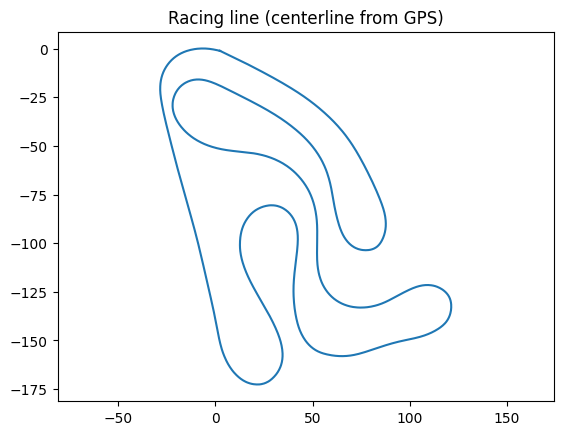

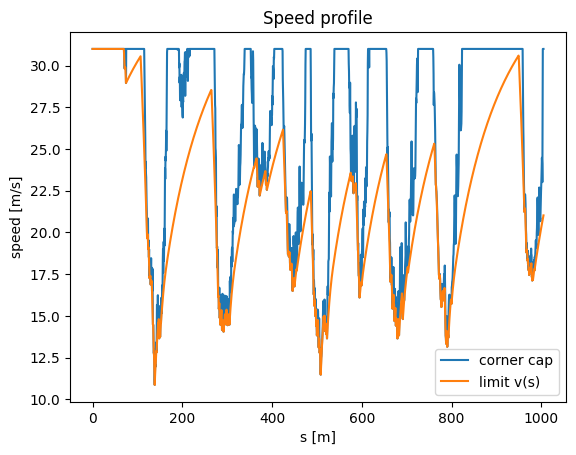

In [2]:
# --- 1) Load AiM / Race Studio CSV and cut the fastest lap ---
CSV_PATH = "../data/2.csv"
df = load_aim_csv(CSV_PATH)
markers_s, seg_times_s = read_markers_and_segments_robust(CSV_PATH)
lap_df, lap_info = extract_fastest_lap(df, markers_s, seg_times_s)
print(f"Fastest lap: {lap_info['lap_time']:.3f} s")

# --- 2) Build a smooth, uniform-s centerline from the lap GPS ---
# Requires the CSV to contain GPS Latitude / GPS Longitude columns
ctr = build_centerline_from_lap(lap_df, lat_col="GPS Latitude", lon_col="GPS Longitude", smooth_window=9, ds=0.5)
s = ctr["s"].to_numpy()
x = ctr["x"].to_numpy()
y = ctr["y"].to_numpy()
psi = ctr["psi"].to_numpy()
kappa = ctr["kappa"].to_numpy()

x, y, psi, kappa = enforce_periodic_endpoints(x, y, psi, kappa)

trk = CenterlineTrack(s, x, y, psi=psi, kappa=kappa)

# --- 4) Lateral cap (corner-limited speed) ---
p = KartParams()
v_cap_straight = 31
S_grid, v_kappa = curvature_speed_profile(trk, a_lat_max=p.mu_lat*9.81, v_cap=v_cap_straight, n=len(s))
ds = float(S_grid[1] - S_grid[0])

curve = iame_x30_curve(scale=0.80) 

def Te_fn(omega_rad_s):
    """Return engine torque [Nm] for engine speed omega [rad/s]."""
    rpm = (np.asarray(omega_rad_s, float) * 60.0) / (2.0 * np.pi)
    return curve.tq(rpm)

# IMPORTANT: pass Te_fn as the 3rd positional arg (or keyword Te_fn=Te_fn)
axmax = lambda v: float(a_x_max(v, p, Te_fn))
axmin = lambda v: float(a_x_min(v, p))

v_opt = forward_backward_speed_profile(S_grid, v_kappa, ds, axmax, axmin)

# --- 6) Quick plots ---
plt.figure(); plt.plot(x, y); plt.axis('equal'); plt.title("Racing line (centerline from GPS)")
plt.figure(); plt.plot(S_grid, v_kappa, label="corner cap"); plt.plot(S_grid, v_opt, label="limit v(s)")
plt.xlabel("s [m]"); plt.ylabel("speed [m/s]"); plt.legend(); plt.title("Speed profile")
plt.show()


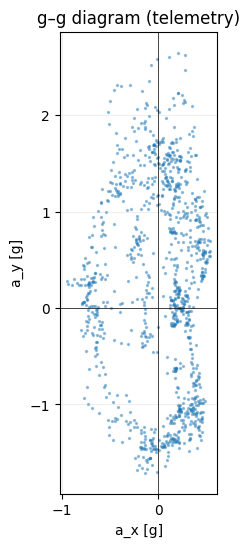

Estimated lateral μ (95th pct): 1.76


In [3]:
# === 9) g–g diagram (telemetry) ===
lat_cols = [c for c in lap_df.columns if "LatAcc" in c]
lon_cols = [c for c in lap_df.columns if "LonAcc" in c]
if lat_cols and lon_cols:
    ay = lap_df[lat_cols[0]].to_numpy(float)
    ax = lap_df[lon_cols[0]].to_numpy(float)
    # If the magnitudes look like 'g' (<= 4..5), convert to m/s^2
    if np.nanmax(np.abs(ax)) <= 5.0 and np.nanmax(np.abs(ay)) <= 5.0:
        ax *= 9.81; ay *= 9.81
else:
    # fallback: finite-difference speed, and ay from kappa
    t = lap_df["Time"].to_numpy(float)
    dt = np.gradient(t)
    v = tele_v
    ax = np.gradient(v, dt)
    k_near = kappa[np.clip(idx, 0, len(kappa)-1)]
    ay = v*v * k_near

plt.figure(figsize=(6,6))
plt.scatter(ax/9.81, ay/9.81, s=2, alpha=0.4)
plt.axhline(0, color='k', linewidth=0.5); plt.axvline(0, color='k', linewidth=0.5)
plt.xlabel("a_x [g]"); plt.ylabel("a_y [g]"); plt.title("g–g diagram (telemetry)")
plt.grid(True, alpha=0.2); plt.gca().set_aspect('equal', 'box')
plt.show()

mu_est = np.percentile(np.abs(ay/9.81), 95)
print(f"Estimated lateral μ (95th pct): {mu_est:.2f}")

Fastest lap: 52.245 s


/home/alexp/projects/vehicle-dynamics-project/src/vdyn/telemetry/aim.py:79: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors="ignore")


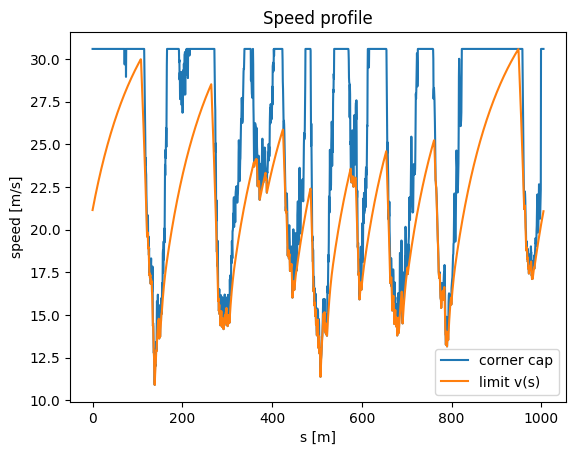

In [5]:
# --- 1) Load AiM / Race Studio CSV and cut the fastest lap ---
CSV_PATH = "../data/2.csv"
df = load_aim_csv(CSV_PATH)
markers_s, seg_times_s = read_markers_and_segments_robust(CSV_PATH)
lap_df, lap_info = extract_fastest_lap(df, markers_s, seg_times_s)
print(f"Fastest lap: {lap_info['lap_time']:.3f} s")

# --- 2) Build a smooth, uniform-s centerline from the lap GPS ---
ctr = build_centerline_from_lap(lap_df, lat_col="GPS Latitude", lon_col="GPS Longitude", smooth_window=9, ds=0.5)
s = ctr["s"].to_numpy()
x = ctr["x"].to_numpy()
y = ctr["y"].to_numpy()
psi = ctr["psi"].to_numpy()
kappa = ctr["kappa"].to_numpy()

x, y, psi, kappa = enforce_periodic_endpoints(x, y, psi, kappa)

trk = CenterlineTrack(s, x, y, psi=psi, kappa=kappa)

def soften_kappa_seam(kappa, W=12):
    """Blend first/last W samples so curvature is continuous at the seam."""
    k = kappa.copy()
    if len(k) < 2*W:  # tiny guard
        return k
    a = np.linspace(0, 1, W)
    k_start = k[:W].copy()
    k_end   = k[-W:].copy()
    # crossfade: last -> first
    k[:W]  = (1 - a) * k_start + a * k_end
    k[-W:] = (1 - a[::-1]) * k_end + a[::-1] * k_start
    return k

# 1) Smooth the curvature seam
kappa_smooth = soften_kappa_seam(trk.kappa, W=12)

p      = KartParams()
S_grid = trk.s
ds     = float(S_grid[1] - S_grid[0])

# 1) Safe curvature cap (general-purpose)
v_cap = 30.6          # ~110 km/h
eps_k = 1e-4          # protects straights / tiny |kappa|
ay    = p.mu_lat * 9.81
v_kappa = np.minimum(np.sqrt(ay / (np.abs(kappa_smooth) + eps_k)), v_cap)

curve = iame_x30_curve(scale=0.80)
def Te_fn(omega_rad_s):
    rpm = (np.asarray(omega_rad_s, float) * 60.0) / (2*np.pi)
    return curve.tq(rpm)

def axmax(v):  # +ve, drive-limited
    return max(0.0, float(a_x_max(v, p, Te_fn=Te_fn)))

def axmin(v):  # -ve, brake-limited
    return min(0.0, float(a_x_min(v, p)))

# 3) Cyclic solver to kill start-of-lap artifacts
def limit_speed_profile_cyclic(S, v_kappa, ds, axmax, axmin, v_cap, iters=3):
    i0   = int(np.argmin(v_kappa))                # move seam to tightest corner
    vkap = np.roll(v_kappa, -i0)

    v = np.minimum(vkap, v_cap).astype(float)
    v[0] = max(1.0, v[0])                        

    for _ in range(iters):
        # forward (accel)
        for i in range(len(v) - 1):
            a = max(0.0, axmax(v[i]))
            v[i+1] = min(v[i+1], np.sqrt(max(0.0, v[i]*v[i] + 2.0*a*ds)))
        # backward (brake)  <-- NOTE the '+' sign
        for i in range(len(v) - 2, -1, -1):
            a = abs(axmin(v[i+1]))                # magnitude of decel
            v[i] = min(v[i], np.sqrt(max(0.0, v[i+1]*v[i+1] + 2.0*a*ds)))
        v = np.minimum(v, vkap)                 

    return np.roll(v, i0)

v_opt = limit_speed_profile_cyclic(S_grid, v_kappa, ds, axmax, axmin, v_cap, iters=3)

# 4) Plot
plt.figure(); plt.plot(S_grid, v_kappa, label="corner cap"); plt.plot(S_grid, v_opt, label="limit v(s)")
plt.xlabel("s [m]"); plt.ylabel("speed [m/s]"); plt.legend(); plt.title("Speed profile"); plt.show()
